In [111]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 

import Helper.Preprocessing as pp 
import Helper.Model_dense as ml 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Explore data


In [112]:
df = pd.read_csv("Data/dataset.csv", sep=",")
df.Date = pd.to_datetime(df.Date)
df = df[df.Date >= pd.to_datetime('2015-01-26')]
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,SARON_close,US_IR,CH_infl,US_infl
2625,2015-01-26,0.8811,0.89790,0.87638,0.8811,0.8811,0.0,"-0,726632","0,02","-0,4","-0,470589237"
2626,2015-01-27,0.9013,0.91596,0.89374,0.9013,0.9013,0.0,"-0,755313","0,02","-0,4","-0,470589237"
2627,2015-01-28,0.8992,0.90896,0.89855,0.8992,0.8992,0.0,"-0,748131","0,02","-0,4","-0,470589237"


In [113]:
Close =  df.Close
US_infl = df.US_infl.apply(lambda x: x.replace(',', '.')).astype(float)
CH_infl = df.CH_infl.apply(lambda x: x.replace(',', '.')).astype(float)
US_IR = df.US_IR.apply(lambda x: x.replace(',', '.')).astype(float)
SARON_close = df.SARON_close.apply(lambda x: x.replace(',', '.')).astype(float)
data = [Close, US_infl, CH_infl,US_IR, SARON_close]

In [114]:
# data = [df.Close, df.US_infl, df.CH_infl, df.US_IR, df.SARON_close]

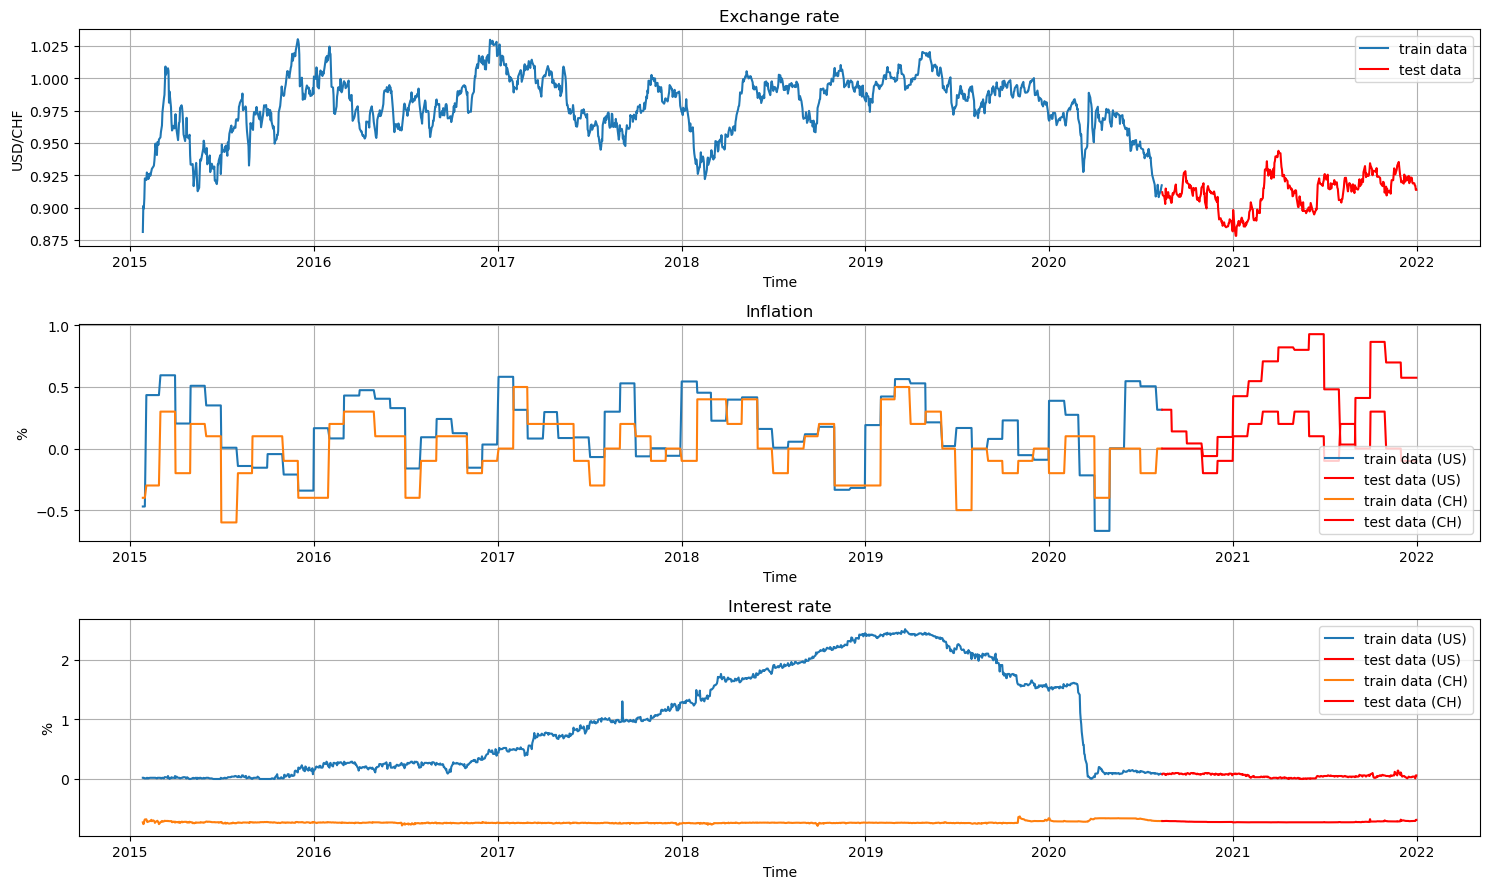

In [115]:
FRACTION_TEST = 0.2
nb_test = int(FRACTION_TEST*len(df))

plt.figure(figsize=(15, 9))

plt.subplot(3,1,1)
plt.title("Exchange rate")
plt.plot(df.Date.values[:-nb_test],df.Close.values[:-nb_test], label="train data")
plt.plot(df.Date.values[-nb_test:], df.Close.values[-nb_test:], color="r", label="test data")
plt.xlabel("Time", fontsize=10)
plt.ylabel("USD/CHF", fontsize=10)
plt.grid()
plt.legend(fontsize=10)

plt.subplot(3,1,2)
plt.title("Inflation")
plt.plot(df.Date.values[:-nb_test],US_infl.values[:-nb_test], label="train data (US)")
plt.plot(df.Date.values[-nb_test:], US_infl.values[-nb_test:], color="r", label="test data (US)")
plt.plot(df.Date.values[:-nb_test],CH_infl.values[:-nb_test], label="train data (CH)")
plt.plot(df.Date.values[-nb_test:], CH_infl.values[-nb_test:], color="r", label="test data (CH)")
plt.xlabel("Time", fontsize=10)
plt.ylabel("%", fontsize=10)
plt.grid()
plt.legend(fontsize=10)

plt.subplot(3,1,3)
plt.title("Interest rate")
plt.plot(df.Date.values[:-nb_test],US_IR.values[:-nb_test], label="train data (US)")
plt.plot(df.Date.values[-nb_test:], US_IR.values[-nb_test:], color="r", label="test data (US)")
plt.plot(df.Date.values[:-nb_test],SARON_close.values[:-nb_test], label="train data (CH)")
plt.plot(df.Date.values[-nb_test:], SARON_close.values[-nb_test:], color="r", label="test data (CH)")
plt.xlabel("Time", fontsize=10)
plt.ylabel("%", fontsize=10)
plt.grid()
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Dataset

In [116]:
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=10, norm_=False, fraction_val_=0.2, fraction_test_=FRACTION_TEST)

Shape:         
X train     (1150, 10, 5), y train     (1150, 5)        
X train val (288, 10, 5) , y train val (288, 5)         
X test      (362, 10, 5) , y test      (362, 5)


Decide which features to consider !!!!!!

In [117]:
variables = [0]

train_x = train_x[:,:,variables]
val_x = val_x[:,:,variables]
test_x = test_x[:,:,variables]

print(train_x[0])

[[0.8811 ]
 [0.9013 ]
 [0.8992 ]
 [0.907  ]
 [0.9225 ]
 [0.9213 ]
 [0.9271 ]
 [0.92475]
 [0.926  ]
 [0.922  ]]


Reshape for NN input

In [118]:
train_x = train_x.reshape(train_x.shape[0], -1)
print(train_x.shape)

val_x = val_x.reshape(val_x.shape[0], -1)
print(val_x.shape)

test_x = test_x.reshape(test_x.shape[0], -1)
print(test_x.shape)

(1150, 10)
(288, 10)
(362, 10)


In [119]:
train_y = train_y[:,0]
val_y = val_y[:,0]
test_y = test_y[:,0]

# Generate model

In [148]:
model = ml.dense_model(num_layers = 4, layer_size = 64, input_size = train_x.shape[1], output_size = 1, dropout=0.2)
model

dense_model(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [149]:
batch_size = 512
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [150]:
device = 'cpu'
num_epochs = 100
criterion_reg = nn.MSELoss()   

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train_loss = []
val_loss = []

for epoch in tqdm.tqdm(range(1, num_epochs+1)):
    avg_loss = 0.
    model.train()

    for x, label in train_loader:
        outputs = model(x.to(device).float())
        optimizer.zero_grad()

        loss = criterion_reg(outputs, label.to(device).float().unsqueeze(1))
        avg_loss += loss.item()
        loss.backward()

        optimizer.step()
    
    # Training loss
    train_loss.append(avg_loss/(len(train_loader)))

    # Validation loss
    model.eval()
    inp = torch.from_numpy(np.array(val_x))
    labs = torch.from_numpy(np.array(val_y))
    out = model(inp.to(device).float())
    outputs = out.cpu().detach().numpy()
    targets = labs.numpy().reshape(-1)
    MSE = np.mean((outputs-targets)**2)
    val_loss.append(MSE)

    if epoch % (num_epochs/10) == 0:
        print("Epoch: %d,\nloss MSE: %f" % (epoch, train_loss[-1])) 
        print("Validation loss MSE: %f" % (val_loss[-1])) 

 12%|█▏        | 12/100 [00:00<00:05, 17.14it/s]

Epoch: 10,
loss MSE: 0.271931
Validation loss MSE: 0.477391


 22%|██▏       | 22/100 [00:01<00:04, 17.18it/s]

Epoch: 20,
loss MSE: 0.079791
Validation loss MSE: 0.125920


 32%|███▏      | 32/100 [00:01<00:04, 16.25it/s]

Epoch: 30,
loss MSE: 0.060202
Validation loss MSE: 0.013981


 42%|████▏     | 42/100 [00:02<00:03, 16.38it/s]

Epoch: 40,
loss MSE: 0.053891
Validation loss MSE: 0.012205


 53%|█████▎    | 53/100 [00:03<00:02, 17.11it/s]

Epoch: 50,
loss MSE: 0.047285
Validation loss MSE: 0.008055


 62%|██████▏   | 62/100 [00:03<00:02, 18.05it/s]

Epoch: 60,
loss MSE: 0.039152
Validation loss MSE: 0.009280


 72%|███████▏  | 72/100 [00:04<00:02, 12.26it/s]

Epoch: 70,
loss MSE: 0.038369
Validation loss MSE: 0.009569


 82%|████████▏ | 82/100 [00:05<00:01, 15.04it/s]

Epoch: 80,
loss MSE: 0.035479
Validation loss MSE: 0.007647


 92%|█████████▏| 92/100 [00:05<00:00, 15.97it/s]

Epoch: 90,
loss MSE: 0.036155
Validation loss MSE: 0.008997


100%|██████████| 100/100 [00:06<00:00, 15.83it/s]

Epoch: 100,
loss MSE: 0.031833
Validation loss MSE: 0.005148


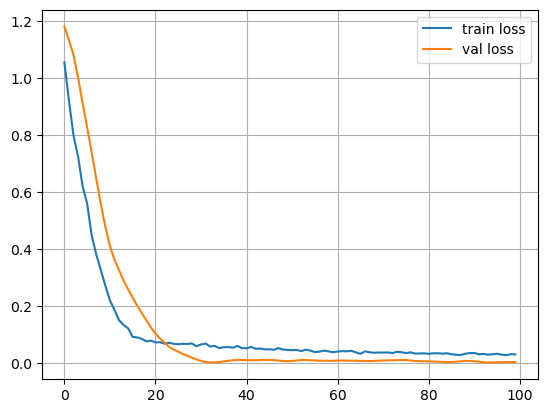

In [151]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.grid()
plt.legend()
plt.show()

In [132]:
def evaluate(model, x_, y_):
    model.eval()

    outputs = []
    targets = []
    
    inp = torch.from_numpy(np.array(x_))
    labs = torch.from_numpy(np.array(y_))

    out = model(inp.to(device).float())
    outputs = out.cpu().detach().numpy()
    targets = labs.numpy().reshape(-1)

    outputs = out.cpu().detach().numpy()
    targets = labs.numpy()

    MSE = np.mean((outputs-targets)**2)
    print("MSE: {}".format(MSE))
    return outputs, targets, MSE

In [136]:
outputs1, targets1, MSE = evaluate(model, train_x, train_y)

MSE: 0.005896527035608215


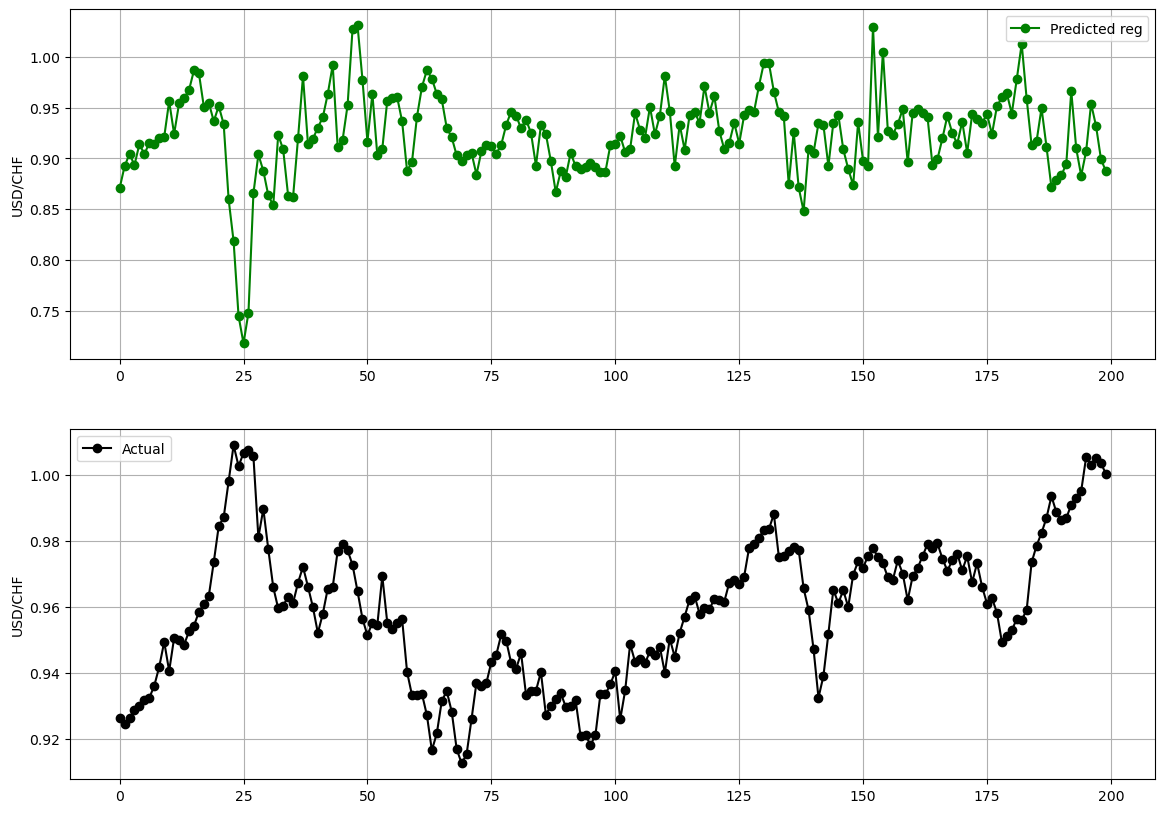

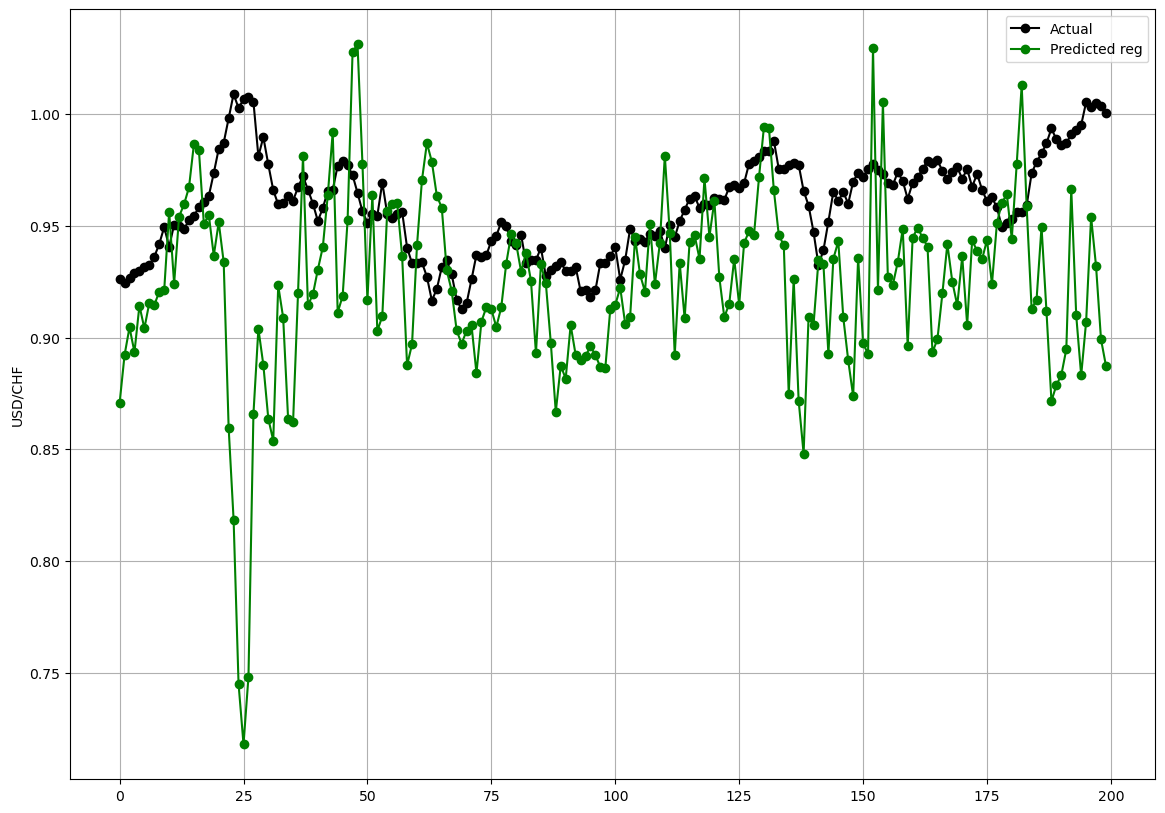

In [137]:
points = range(0,200)
# points = range(len(outputs1))

plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
plt.plot(outputs1[points], "-o", color="g", label="Predicted reg")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(targets1[points],"-o", color="k", label="Actual")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()

#######
plt.figure(figsize=(14,10))
plt.plot(targets1[points],"-o", color="k", label="Actual")
plt.plot(outputs1[points], "-o", color="g", label="Predicted reg")
plt.ylabel('USD/CHF')
plt.grid()
plt.legend()